# MAUP exercise: Putting demographic and election data together

Our goal in this exercise is to get demographic data onto precincts. This requires two stages:
- since CVAP data is only available at the block group (BG) level, we need to disaggregate CVAP onto blocks
- we then need to aggregate demographic data (including CVAP) up to precincts

![Using maup to get demographic data onto precincts](maup.png "Summary")

## Part 1: Disaggregating CVAP from block groups to blocks

### Looking at block and block group data

Let's load block group and block shapefiles, and see what fields they have.

In [ ]:
import geopandas as gpd
import maup
import matplotlib.pyplot as plt

In [207]:
#load a block group shapefile
block_groups = gpd.read_file("lowell_bgs.shp")

In [ ]:
#let's look at the block group data a bit
block_groups.plot()
print("There are {} rows in the shapefile".format(len(block_groups)))
print("The block group shapefile has columns: ", block_groups.columns)

In [ ]:
#load a block shapefile
blocks = gpd.read_file("lowell_blocks.shp")

In [ ]:
#let's look at the data a bit
blocks.plot()
print("There are {} rows in the shapefile".format(len(blocks)))
print("The block group shapefile has columns: ", blocks.columns)

Notice that the blocks shapefile doesn't have CVAP, but the block group shapefile does. We want to use the block group CVAP data to get approximate CVAP on blocks. To give you some intuition for how this works, let's look at just one block group.

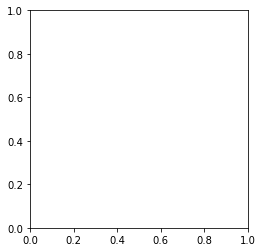

In [206]:
#pull out one block group
example_block_group = block_groups[42:43]
example_block_group.plot()

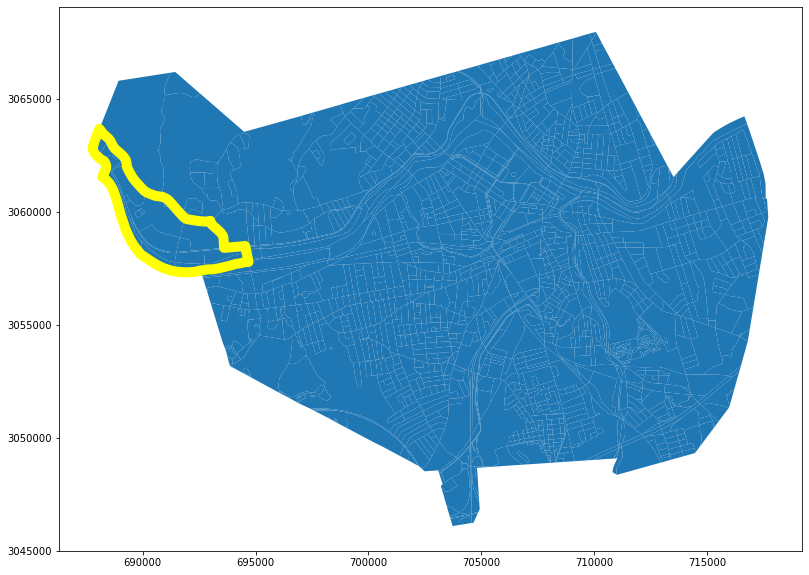

In [203]:
fig, ax = plt.subplots(figsize=(20,10)) #makes the figure nice and big
blocks.plot(ax=ax)
example_block_group.boundary.plot(ax=ax,color='yellow', linewidth=10)

As you can see, our block group contains many blocks. One simple idea would be to divide the CVAP in the block group equally among all the blocks in it. Take a minute and think for yourself whether this is a good idea before proceeding on.

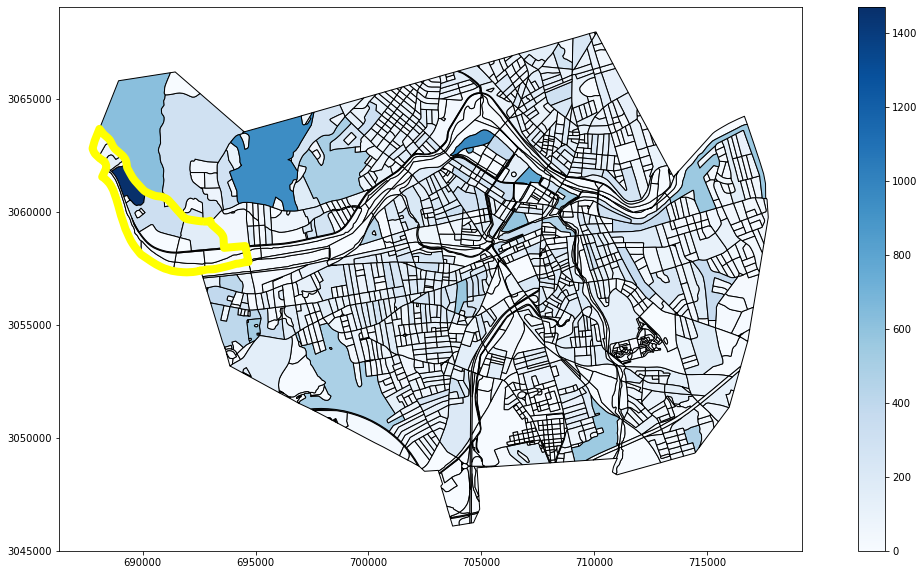

In [204]:
#plot the same plot, but with population shown for blocks
fig, ax = plt.subplots(figsize=(20,10)) #makes the figure nice and big
blocks.plot(ax=ax, column='TOTPOP', cmap='Blues',legend=True,edgecolor='black')
example_block_group.boundary.plot(ax=ax,color='yellow', linewidth=8)

### The plot above shows the population by block. Most of the population is in just one block! It's therefore not realistic to share the CVAP equally among all the blocks in our block group. Instead, we should give CVAP to each block according to its population. This is what we refer to as _proration_ or _disaggregation_.

### Using MAUP for disaggregation

Fortunately, the MAUP package does this process for us. Let's give it a shot. The first thing we must ALWAYS do is make sure the two shapefiles (blocks and block_groups) are in the same projection!

In [ ]:
#let's find out which projection the block shapefile is in
blocks.crs

In [ ]:
#let's reproject them to a local MA projection
blocks = blocks.to_crs({"init":"epsg:2249"})

In [ ]:
#project block_groups to same projection as blocks
block_groups = block_groups.to_crs(blocks.crs)

In [ ]:
#this assigns blocks to block groups than contain it (this can take a while with big shapefiles!)
assignment = maup.assign(blocks, block_groups)

In [ ]:
#this gets us the weighting for each block by population
weights = blocks.TOTPOP / assignment.map(block_groups.TOTPOP)

In [ ]:
#these are the columns we want to prorate to blocks
columns = ['CVAP', 'CVAPHISP', 'CVAPWHITE', 'CVAPASIAN']

In [ ]:
#now we do the proration from block groups onto blocks
prorated = maup.prorate(assignment, block_groups[columns], weights)
#remember to put the new data onto the blocks
blocks[columns] = prorated

That's it! We've put CVAP on blocks. Let's take a look at our new data. Let's plot blocks showing the percent of the population that are voting age citizens.

In [ ]:
blocks.plot(column=blocks.CVAP.divide(blocks.TOTPOP),cmap='Blues', legend=True)

In [ ]:
#let's save our file so we can open it later
blocks.to_file("lowell_blocks_with_new_data.shp")

*Extra challenge (optional):* By making more plots, find some other demographic stats that look like they are correlated (or anti-correlated) with the percent of the population that are voting age citizens.

### Sanity checks!

Let's do at least one check to make sure we didn't mess up.

In [ ]:
#the total CVAP using the block group shapefile
print("TOTAL CVAP using block groups:", block_groups['CVAP'].sum())

In [ ]:
#the total CVAP using the block shapefile
print("TOTAL CVAP using blocks:", blocks['CVAP'].sum())

There may be some rounding error, but the numbers should be roughly the same.

## Part 2: Aggregating demographic data from blocks to precincts

### Exploring precinct and block data

Let's load some voting precincts, and take a look at how they look over blocks.

In [ ]:
#load a precinct shapefile
precincts = gpd.read_file("lowell_precincts.shp")

In [ ]:
#reproject the precincts
precincts = precincts.to_crs({"init":"epsg:2249"})

In [ ]:
fig, ax = plt.subplots(figsize=(20,10)) #makes the figure nice and big
blocks.plot(ax=ax)
precincts.boundary.plot(ax=ax,color='yellow', linewidth=3)

### Using MAUP to aggregate demographic data up to precincts

We want to add demographic data to our precinct shapefile. This time, we are going from smaller units (blocks) to larger units (precincts), so we are going to just add up all the block data in each precinct. Sometimes a block touches multiple precincts, which makes things hard. Fortunately, MAUP handles that for us by choosing the precinct with the highest overlap.

In [ ]:
#this gives us an assignment for each block to the best precinct for it
assignment = maup.assign(blocks, precincts)

In [ ]:
#these are the columns we want to add to our precincts
variables = ['TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'CVAP', 'CVAPHISP', 'CVAPWHITE',
       'CVAPASIAN']

In [ ]:
#now we need to add up the data for each precinct
precincts[variables] = blocks[variables].groupby(assignment).sum()

That's it! We've used blocks to put demographic data on precincts. Let's take a quick look at our new data. We'll plot the precincts colored by how much of their CVAP is Hispanic.

In [ ]:
precincts.plot(column=precincts.CVAPHISP.divide(precincts.CVAP),cmap='Blues',legend=True)

In [ ]:
#let's save our file
precincts.to_file("lowell_precincts_with_new_data.shp")

### Sanity checks!

In [ ]:
#the total CVAP using the block group shapefile
print("TOTAL CVAP using blocks:", blocks['CVAP'].sum())
#the total CVAP using the block group shapefile
print("TOTAL CVAP using precincts:", precincts['CVAP'].sum())

# Summary

Let's summarize what we have done in this exercise. Our goal was to get demographic data onto precincts. Some of it was at the block level and some was at the block group level. We therefore _disaggregated_ CVAP from block groups to blocks and then _aggregated_ the CVAP data and the data that was already on the blocks up to precincts. Here's a picture of what we did:

![Using maup to get demographic data onto precincts](maup.png "Summary")

# Next steps

As a next step (if you have time), why don't you try doing all of this for Everett MA, another city where the MGGG analyzed electoral reform in the context of minority representation. You can go and change the code above directly, or write/paste your own code in the blocks below. Jupyter notebooks (that's what this code is in) are designed for play!

Some prepared files are already available:
- everett_bgs.shp (block groups)
- everett_blocks.shp (blocks)
- everett_precincts.shp (precincts)

You may have to change the column names as you go (CVAPHISP may be called HCVAP, for example), but that's part of the experience.